<h1> BBHs merging catalog generator V2.0</h1> 

In the following, we'll implement a notebook that, given a certain volume of sky, will return a catalog of possible BBHs merging events.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott T1](https://arxiv.org/abs/1811.12940), [B. P. Abbott T2](https://arxiv.org/abs/2010.14533).
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<h2> Mass distribution functions </h2>

Let's start by defining the probability distribution in function of the masses.

We have :

In [2]:
# Model B mass distribution function of the paper arxiv 1811.12940

# Mass Distribution parameters (values taken from the results of arxiv 1811.12940)

#m_min = 5. # Solar Masses
#m_max = 50. # Solar Masses
#alpha = 1.6 # +-1.6 Big Error !
#beta_q = 6.7 # +4.8 -5.9 Still Big Error !

# Function for estimating the Phase Space costant of the Mass distribution

#def ModBPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q):
#    
#    ris = 0.
#    
#    for i in range(len(ran_m1)- 1):
#        for j in range(len(ran_m2)- 1):
#            if(ran_m1[i] >= m_min and ran_m1[i] <= m_max and ran_m2[j] <= ran_m1[i] and ran_m2[j] >= m_min):
#                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
#                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
#                q = mid_m2/mid_m1 
#                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*(np.power(mid_m1, (-alpha))*np.power(q, beta_q))
#   
#    return ris

# Function for the distribution in function of mass (as used in paper arxiv 1811.12940)

#def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, C_norm):
#    if(m1 >= m_min and m1 <= m_max and m2 <= m1 and m2 >= m_min) :
#        q = m2/m1
#        return (C_norm*np.power(m1, (-alpha))*np.power(q, beta_q))
#    else :
#        return 0.

In [3]:
# Power law + Peak Mass Model of the paper arxiv 2010.14533

# Mass Distribution parameters (values taken from the results of arxiv 2010.14533)

m_min = 5. # Solar Masses (in the paper 4.53 + 1.47 - 1.89 Solar Masses)
m_max = 100. # Solar Masses (in the paper 86.73 + 11.56 - 12.37 Solar Masses)
alpha = 2.62 # +0.73 - 0.62
beta_q = 1.26 # +2.37 -1.62 
delta_m = 4.88 # + 4.10 -4.25 Solar Masses 
lambda_peak = 0.10 # +0.14 -0.07 
mu_m = 33.49 # +4.54 -5.51 Solar Masses
sigma_m = 5.09 # +4.28 - 4.34 Solar Masses

# Defining of the smoothing function for m close to the minimimum mass

def MassSmoothing(m, m_min, delta_m):
    if(m < m_min):
        return 0.
    else:
        if(m >= (m_min + delta_m)):
            return 1.
        else:
            factor = np.exp((delta_m/(m - m_min)) + (delta_m/(m - m_min - delta_m)))
            return 1./(factor + 1.)

# Defining a normalized power law distribution function, needed for the final distribution function        
        
def MassPowLaw(m, m_min, m_max, alpha, PL_norm):
    if(m_min < m < m_max):
        return (1./PL_norm)*(m**(-alpha))
    else:
        return 0.
    
# Estimating the Phase space of the Power law distribution using trapezoidal integration
    
def PowerLawPS(ran_m1, m_min, m_max, alpha):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
       if(ran_m1[i] >= m_min and ran_m1[i] <= m_max):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                ris +=  (ran_m1[i + 1] - ran_m1[i])*(np.power(mid_m1, (-alpha)))
   
    return ris

    
# Defining a Gaussian distribution of the mass, needed for the final distribution function

def MassGauss(m, mu_m, sigma_m, GS_norm):
    return ((1./(sigma_m*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-mu_m)/sigma_m)**2.))*1./GS_norm

def GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
       if(ran_m1[i] >= m_min and ran_m1[i] <= m_max):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                ris +=  (ran_m1[i + 1] - ran_m1[i])*((1./(sigma_m*np.sqrt(2.*np.pi)))*np.exp(-0.5*((mid_m1-mu_m)/sigma_m)**2.))
   
    return ris


# Defining the proper Mass distribution function

def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, Mass_PS):
    
    if(m1 > m2):
        return ((1. - lambda_peak)*MassPowLaw(m1, m_min, m_max, alpha, PL_norm) + \
                lambda_peak*MassGauss(m1, mu_m, sigma_m, GS_norm))*MassSmoothing(m1, m_min, delta_m)*\
                ((m2/m1)**(beta_q))*MassSmoothing(m2, m_min, delta_m)*(1./Mass_PS)
    else:
        return 0.


# Estimating the Phase space for the Model C Mass distribution function using trapezoidal integration

def ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, Mass_PS):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
        for j in range(len(ran_m2)- 1):
             if(ran_m1[i] >= ran_m2[j]):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
                q = mid_m2/mid_m1 
                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*((1. - lambda_peak)\
                *MassPowLaw(mid_m1, m_min, m_max, alpha, PL_norm) + lambda_peak*MassGauss(mid_m1, mu_m, sigma_m, GS_norm))\
                *MassSmoothing(mid_m1, m_min, delta_m)*(q**(beta_q))*MassSmoothing(mid_m2, m_min, delta_m)\
                *(1./Mass_PS)
   
    return ris
    

and we will also need a function that return the Chirp Mass, given the mass of the two events involved in the binary merging :

In [4]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

<h2> Redshift dependent statistic </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [5]:
# Just a function to convert from Z to GPC using Hubble Law

def Z_to_Gpc(z):
    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 1

and the function that estimates the differential comoving volume in function of the redshift :

In [6]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z):
    r = Z_to_Gpc(z)    
    return ((4.*c*(10**(-3))*np.pi*(r**2.))/(H_0))

We may now define, the merging rate as a function of the redshift _z_ as :

In [7]:
# Constant merging rate throughout the volume as fitted in the paper arxiv 1811.12940

#def R(z):
#    return 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume

In [8]:
# Function for the merging rate as described in the paper arxiv 2010.14533, the flag Red_evol will decide if adopting a merging rate the evolve with redshift (true) or not (false)

def R(z):
    if(Red_evol):
        R_0 = 19.1 # +16.2 - 9.0 GPc^-3 yr⁻1
        k = 1.3 # +2.1 - 2.1 VALID FOR POWER LAW + PEAK MODEL MASS DISTRIBUTION
        return R_0*(1+z)**(k)
    else:
        R_0 = 23.9 # +14.9 - 8.6 GPc^-3 yr^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate
        return R_0        


<h2> Spin distribution functions </h2>

Now let's define the spin distribution function as a Beta function :

In [9]:
#Spin Amplitude Distribution parameter (values taken from the paper arxiv 2010.14533)

Expected_a = 0.25 # +0.09 - 0.07
Var_a = 0.03  # +0.02 - 0.01
a_max = 1.


def BetaSpinParameters(Expected_a, Var_a):
    expec_rel = (Expected_a/(1. - Expected_a))
    beta_a = ((expec_rel - Var_a*np.power(1. + expec_rel, 2.))/(Var_a*np.power(1. + expec_rel, 3.)))
    alpha_a = expec_rel*beta_a
    return alpha_a, beta_a

alpha_a, beta_a = BetaSpinParameters(Expected_a, Var_a)

if(alpha_a <=1 or beta_a <=1):
    print('Error in the selection of the values for E[a] and Var[a]')

# Estimating the beta function, that will be used as a normalization constant, by using the trapeze method to avoid problems in the extremes

def Beta_Func(span_a, alpha_a, beta_a):
    ris = 0.
    for i in range(len(span_a)- 1):
        mid_a = 0.5*(span_a[i + 1] + span_a[i])
        ris +=  (span_a[i + 1] - span_a[i])*(np.power(mid_a,(alpha_a - 1.))*np.power((1. - mid_a),(beta_a - 1.)))
   
    return ris

# Distribution for the spin amplitude, the beta distribution could get values bigger than 1 !

def SpinModDistrib(a, alpha_a, beta_a, Beta_Val):
     
    return ((np.power(a, alpha_a - 1.)*np.power(1. - a, beta_a - 1.))/(Beta_Val))

<h2> Number of events in function of the parameters </h2>

We may finally define the distribution function for the number of events :

In [10]:
# Density function for the events in function of the parameters

def NDistrib(z,m1,m2,a_1,a_2):
    n = R(z)*DeVC(z)*(T_tot /(1. + z)) \
    *MassDistr(m1, m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, Mass_PS) \
    *SpinModDistrib(a_1, alpha_a, beta_a, BetaVal)*SpinModDistrib(a_2, alpha_a, beta_a, BetaVal)
    return n

<h2> Frequency of the generated events </h2>

Here we implement a function to roughly estimate the initial orbital frequency of the event given the massess and the residual coalescence time, as taken by **equation 11 a)** of [S. Marsat and J. G. Baker](https://arxiv.org/pdf/1806.10734.pdf); from that equation we may also estimate the residual time for the events frequency to go outside of the LISA band :

In [11]:
#This function given the mass of the two events and the residual time to coalescence, return the initial frequency of the event at the LISA detection time
def GetInitialFrequency(m1,m2,coal_T):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = ((256.*ni)/(5.*np.power((c*(10.**3.)),5.)))*np.power((G*M*sol_mass),(5./3.))*coal_T
    return (np.power(res,(-(3./8.)))/np.pi)

In [12]:
#This function given the mass of the two events and the max frequency detectable, return the residual time that the event will spend on the Lisa band
def TimeOutFrqRange(m1,m2,f_max):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = (5.*np.power((c*(10.**3.)),5.))/(256.*ni*np.power((np.pi*f_max),(8./3.))*np.power((G*M*sol_mass),(5./3.)))
    return res/year

<h2> Functions for the generation of the catalogue </h2>

Let's start by defining a function that randomly generate a name for the single events, just to make the result appear sexier :

In [13]:
# This function will generate a fake name for the event in the time range of the LISA mission, it will not generate events in the day 29,30,31

def Gen_Event_name():
    
    month = random.randrange(12) + 1
    day = random.randrange(28) + 1
    nid = str(random.randrange(1000) + 1)
    
    if month < 10 :
        month = '0'+ str(month)        
    else:
        month = str(month)
        
    if day < 10 :
        day = '0'+ str(day)        
    else:
        day = str(day)    
        
    return "GW"+ str(random.randrange(34,37))+ month + day +"NId"+ nid


We may hence define a function that will give a uniform random value in the considered bin, this function will smoothen up the values of the generated catalogue in order to not have a single representant parameter for each of the considered bin :

In [14]:
# Generate a number of events equal to the lenght of the array N_EvXBin, with random values in the phase deltavolume for each of the parameter

def Gen_Events_Parameters(idx_m1, idx_m2, idx_z, idx_a1, idx_a2) :
                                
        ev_m1 = random.uniform(ran_m1[idx_m1],ran_m1[idx_m1 + 1])
        ev_m2 = random.uniform(ran_m2[idx_m2],ran_m2[idx_m2 + 1])
        ev_z = random.uniform(ran_z[idx_z],ran_z[idx_z + 1])
        
        # If SNR Cut implemented, checking if the event SNR is bigger than the treshold, if not just generating the events
        
        if((not SNR_Cut) or (SNR_Cut and (ChirpMass(ev_m1, ev_m2) >SNR_Cutoff(ev_z)))):
        
            # By convention we impose that m1 is the biggest mass among the 2
            if(ev_m2 > ev_m1):
                app = ev_m1
                ev_m1 = ev_m2
                ev_m2 = app
            ev_ttilde = random.uniform(0., max_tc)                            
            ev_ifrq = GetInitialFrequency(ev_m1,ev_m2,ev_ttilde*year)
        
            # If the event frequency is within the LISA band the others parameters would be generated, in the other case the event is rejected 
        
            if(ev_ifrq <= frq_max):
            
            
                #ev_nm = Gen_Event_name()
            
                ev_sa1 = random.uniform(ran_a_1[idx_a1],ran_a_1[idx_a1 + 1])
                ev_sa2 = random.uniform(ran_a_2[idx_a2],ran_a_2[idx_a2 + 1])
            
                # As we imposed the simmetry of the spin amplitude distribution, and we run the simulation over sa1 > sa2 by doubling the generated events, let's give a chance to invert the spin among the 2 
            
                if(np.random.random() >= 0.5):
                    app = ev_sa1
                    ev_sa1 = ev_sa2
                    ev_sa2 = app            
            
                # Appending the generated event to the catalogue
            
                BH = pd.DataFrame([[ev_z, ev_m1, ev_m2, ev_ifrq, ev_ttilde, ev_sa1, ev_sa2],],\
                                columns = ['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'CoalTime', 'Spin1', 'Spin2'])
                return BH
            else:
                BH = pd.DataFrame({'none' : []})
                return BH
            
        else:
            BH = pd.DataFrame({'none' : []})
            return BH
            
          
                

<h2> Cutoff function for events with low SNR </h2>

The next function, may be used to cut-off from the catalogue generation all the events having an SNR ~< 1.
This will be done after fitting from a previously generated catalogue the countour line having SNR = 1, the values for the fit function was given by [Mauro Pieroni](https://inspirehep.net/authors/1408985) :

In [15]:
# Function to estimate the minimum Chirp Mass giving the redshift in order to obtain a merging event having SNR ~1

fit_par = {}

fit_par[0] = 1.19731015
fit_par[1] = 19.46319054
fit_par[2] = 0.60439631

def SNR_Cutoff(z):
    return (fit_par[0] + fit_par[1]*(z/np.sqrt(0.1))**fit_par[2])
    

<h2> Parallelized function for the generation of the population </h2>

In [16]:
# This function, will parallelize the nested cycles splitting that in function of the mass_1 bin, each process will then estimate the number of events for the given mass_1 bin and generate the events to append to the dataframe

def init_globals(Nr,Ne,Prc):
    global Nreal,Nev,Perc
    Nreal = Nr
    Nev = Ne
    Perc = Prc

def  Bin_and_Gen(d,im1) :
    # Let's use the fact that the mass probability distribution gives 0 for m2 > m1 
    for im2 in (range(im1 + 1)):
        for iz in range(len(ran_z) - 1):
            for ia_1 in range(len(ran_a_1)-1):
                # Let's use the symmetry of the spin amplitude distribution to just run over s_a1 > s_a2, the number of events outside the diagonal should be multiplied by 2
                for ia_2 in range(ia_1 + 1):
                    
                            nstep =  NDistrib(st.mean([ran_z[iz],ran_z[iz + 1]]),st.mean([ran_m1[im1],ran_m1[im1 + 1]]),st.mean([ran_m2[im2],ran_m2[im2 + 1]]),st.mean([ran_a_1[ia_1],ran_a_1[ia_1 + 1]])\
                                     ,st.mean([ran_a_2[ia_2],ran_a_2[ia_2 + 1]]))
                            # to obtain the real result of the integral, we now need to multiply for the 4 factor due to the used simmetries of spin amplitude and spin tilt distribution, time the values of the delta of all the integration variables  
                            
                            nstep *= 4.*(ran_z[iz +1] - ran_z[iz])*(ran_m1[im1 + 1] - ran_m1[im1])*(ran_m2[im2 + 1] - ran_m2[im2])*(ran_a_1[ia_1 + 1] - ran_a_1[ia_1])*(ran_a_2[ia_2 + 1] - ran_a_2[ia_2])
                                     
                            
                            # If we are on the diagonal bin for ia or ict, we don't need to multiply the events by 2 !
                            
                            if(ia_1 == ia_2) : nstep = nstep / 2.    
                            
                            # Addint the fraction of events to the cumulative sum
                            
                            with Nreal.get_lock():            
                                Nreal.value += nstep 
                            
                            # Checking if mode_fast_mc and implementing
                                                        
                            if(mode_fastmc):
                                if(nstep >=1.):
                                    if(nstep - round(nstep) >= 0):
                                        res = nstep - round(nstep)
                                        if(np.random.random() <= res):
                                            nstep = round(nstep) + 1.
                                    else:
                                        res = nstep + 1. - round(nstep)
                                        if(np.random.random() >= res):
                                            nstep = round(nstep) - 1.
                                else:
                                        if(np.random.random() <= nstep):
                                            nstep = 1.
                            
                            # Checking if mode exotic
                                        
                            if(mode_ex):
                                nstep += (np.random.random()*0.5)
                                
                            # The value need to be round up to an integer
                            nstep = round(nstep)
                                                                                    
                            with Nev.get_lock():
                                Nev.value += int(nstep)
                            
                            # The estimated number of events will now be generated, if mode SNR_cut the program will try to generate only if events with SNR bigger than cut are possible
                            
                            if((not SNR_Cut) or (SNR_Cut and (ChirpMass(ran_m1[im1 +1], ran_m2[im2 +1]) > SNR_Cutoff(ran_z[iz])))):
                            
                                for i in range(int(nstep)):
                                    delta_BH = Gen_Events_Parameters(im1, im2, iz, ia_1, ia_2)
                                    if(not delta_BH.empty):
                                        d.append(delta_BH)

    # Increase the percentage index and print percentage
    
    with Perc.get_lock():
         Perc.value += 1
         print('Percentage of completition : ',(Perc.value*100.)/(len(ran_m1)-1), '%')

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [17]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

mode_ex = False
mode_fastmc = False
Red_evol = False
SNR_Cut = False
sel_rs = False

# Number of jobs spawned by the multiprocessing part of the program (use 9/10 * number of core to avoid problems)

n_jobs = (mp.cpu_count() - 4)

# To avoid to saturate the ram when copying the generated list to a dataframe, the process will be made by slicing the list in percentage

cp_perc = 0.1 # If ram > 16 GB put cp_perc = 1 to do the copy in one single step

# Merger distribution parameters

T_obs = 3. # Lisa estimated years of observation
max_tc = 1000. # max years of coalescence time for a BBH mergine event 
zmax = 1. # z value corrispondent to 2 gigaparsec
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive 

#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
H_0 = 67.8 # Hubble constant in Km/(s*MPc)
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

mass_prec = 100           # Binning density for the masses
z_prec = 20             # Binning density for the redshift (affect distance density)
spin_ampl_prec = 20      # Binning density for the spin amplitudes

<h2> Colormaps of the probability functions and check of reliability </h2>

Let's plot the colormaps of the probability functions to check how they behave :

The integrated probability for all possible mass pairs  before normalization is :  3.923728545020766
The integrated probability for all possible mass pairs after normalization is :  0.9999999999999949


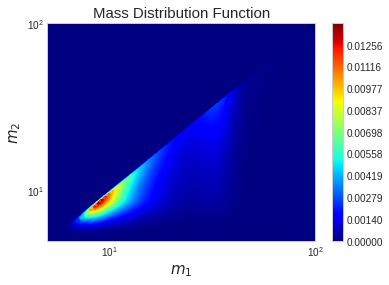

In [18]:
# Colormap of the mass distribution function

Z = np.zeros((250,250))
ran_m1 = np.linspace(m_min,m_max,250)
ran_m2 = np.linspace(m_min,m_max,250)
X, Y = np.meshgrid(ran_m1, ran_m2)

# Mass distribution model B used for the simulation with the values of arxiv 1811.12940

# MassPhaseSpace = ModBPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)

# Mass distribution model C used for the simulation with the values of arxiv 2010.14533

PLPS = PowerLawPS(ran_m1, m_min, m_max, alpha)
GSPS = GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m) 
Mass_PS = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, 1.)

print('The integrated probability for all possible mass pairs  before normalization is : ', Mass_PS) 

for i in range(len(ran_m1) -1):
    for j in range(len(ran_m2) - 1):
        
        # Value of the colormap for the mass distribuction used in arxiv 1811.12940, it is estimated with a trapezoid formula to avoid singularities in the extremes
        
        # Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
        
        # Value of the colormap for the mass distribuction used in arxiv 2010.14533, it is estimated with a trapezoid formula to avoid singularities in the extremes
        
        Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, Mass_PS)
        
        # Fulfill the borders of the colormap by extending the nearest value
        
        if(i == (len(ran_m1) -2)):
            #Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
            Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, Mass_PS)
        if(j == (len(ran_m2) -2)):
            #Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
            Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, Mass_PS)
        
Z[len(ran_m2) - 1][len(ran_m1) -1] = MassDistr(0.5*(X[len(ran_m2) - 1][len(ran_m1) -2] + X[len(ran_m2) - 1][len(ran_m1) -1]), 0.5*(Y[len(ran_m2) - 2][len(ran_m1) - 1] + Y[len(ran_m2) - 1][len(ran_m1) -1]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, Mass_PS)

# Plotting the countour plot

plt.contourf(X, Y, Z, 1000, cmap='jet')
plt.colorbar();
plt.xlabel(r'$m_1$', fontsize = 15)
plt.ylabel(r'$m_2$', fontsize = 15)
plt.title('Mass Distribution Function', fontsize = 15)
plt.loglog()
plt.savefig('MassDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, Mass_PS)



print('The integrated probability for all possible mass pairs after normalization is : ', totprob) 

The integrated probability for all possible spin amplitudes is :  0.9999999999999987


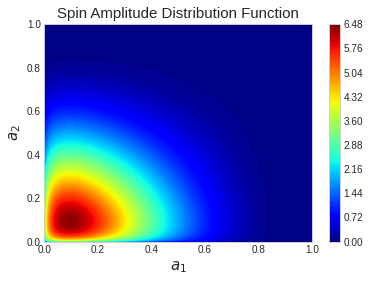

In [19]:
# Colormap of the spin amplitude distribution function, it may be observed the symmetry for swaps among a_1 and a_2

Z = np.zeros((250,250))
ran_a1 = np.linspace(0.,a_max,250)
ran_a2 = np.linspace(0.,a_max,250)
BetaVal = Beta_Func(ran_a1, alpha_a, beta_a)
X, Y = np.meshgrid(ran_a1, ran_a2)

for i in range(len(ran_a1) -1):
    for j in range(len(ran_a2) -1):
        Z[j][i] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)
        
        # Fulfill the borders of the colormap by extending the nearest value
        
        if(i == (len(ran_a1) -2)):
            Z[j][i+1] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)
        if(j == (len(ran_m2) -2)):
            Z[j+1][i] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)
        
Z[len(ran_a2) - 1][len(ran_a1) -1] = SpinModDistrib(0.5*(X[len(ran_a2) - 1][len(ran_a1)-2] + X[len(ran_a2) - 1][len(ran_a1) -1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[len(ran_a2) - 2][len(ran_a1) -1] + Y[len(ran_a2) - 1][len(ran_a1) -1]), alpha_a, beta_a, BetaVal)

# Plotting the countour plot
        
plt.contourf(X, Y, Z, 100, cmap='jet')
plt.colorbar();
plt.xlabel(r'$a_1$', fontsize = 15)
plt.ylabel(r'$a_2$', fontsize = 15)
plt.title('Spin Amplitude Distribution Function', fontsize = 15)
plt.savefig('SpinAmpDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_a1)-1):
    for j in range(len(ran_a2)-1):
        totprob += (ran_a1[i + 1] - ran_a1[i])*(ran_a2[j + 1] - ran_a2[j])*SpinModDistrib(st.mean([ran_a1[i],ran_a1[i+1]]), alpha_a, beta_a, BetaVal)*SpinModDistrib(st.mean([ran_a2[j],ran_a2[j+1]]), alpha_a, beta_a, BetaVal)

print('The integrated probability for all possible spin amplitudes is : ', totprob)        

Let's reset the predefined array to avoid RAM consumption :  

In [20]:
X, Y, Z = np.zeros(1),np.zeros(1),np.zeros(1)

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [21]:
# Initialization of the mass phase space

ran_m1 = np.linspace(m_min,m_max,mass_prec)
ran_m2 = np.linspace(m_min,m_max,mass_prec)
PL_norm = PowerLawPS(ran_m1, m_min, m_max, alpha)
GS_norm = GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m) 
Mass_PS = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, 1.)

# Initialization of the distance phase space

ran_z = np.linspace(0.,zmax, z_prec)    # Don't put bins too small or the volume wouldn't be enough to generate events

# Initialization of the spin amplitude phase space

ran_a_1 = np.linspace(0., a_max,spin_ampl_prec)
ran_a_2 = np.linspace(0., a_max,spin_ampl_prec)
BetaVal = Beta_Func(ran_a_1, alpha_a, beta_a)


and the result will be saved in the BHCat dataframe :

In [22]:
BHCat = pd.DataFrame(columns=['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'InBandTime', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

# The Lisa Dataframe instead will be saved without the EventName and will have the following variables and unit of measure 

SOBBHsunits = {

'Redshift': 'Unit',\
    
'Mass1': 'SolarMass',\
    
'Mass2': 'SolarMass',\

'InitialFrequency' : 'Hertz',\
    
'InBandTime' : 'Years',\

'EclipticLongitude' : 'Radian',\
    
'EclipticLatitude' : 'Radian',\
    
'Inclination' : 'Radian',\

'Polarization' : 'Radian',\
    
'InitialPhase' : 'Radian',\
    
'CoalTime' : 'Years',\
    
'Distance' : 'GigaParsec',\

'Spin1' : 'Unit',\
    
'Spin2' : 'Unit',\
    
'AzimuthalAngleOfSpin1' : 'Radian',\
    
'AzimuthalAngleOfSpin2' : 'Radian'    

}

In [23]:
# Example of the format of an added merging event
#BH= pd.DataFrame([[0.2,2 4.6, 18.3, 0.2, 128.5, -0.9, 4.25, 2.4, 1.6, 5.2, 251., 0.8, 0.2, 0.15, -0.2,0.4],], columns=['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

<h2> FLAG selection section </h2>

The standard way of simulating the events will generate the same number of events in the same range of variables every time it was run...
To give to the simulation a little bit of randomness, and allow the generation of merging events with exotic range of variable, set the **exotic_mode** flags to true. 

In [24]:
#mode_ex = True # If true, in each volume of the phase space it will randomly add a number between [0,0.5]

In alternative, the events may be simulated using a fast Monte Carlo method, to do so set the **mode_fastmc** flag to true.\
**Beware, only one mode flag may be setup at a single time !**

In [25]:
mode_fastmc = True # If True, on each bin will generate a random uniform value and if the value is within the probability range a new event will be added

We may also decide to simulate the catalogue with a redshift evolving merging rate, by setting to true the Red_evol flag:

In [26]:
Red_evol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume

Lastly, we may set the flag SNR_Cut if we wish to simulate only events with chirpmass bigger than the value defined by the SNR_Cutoff function, this will only generate events with SNR bigger then the imposed treshold value :

In [27]:
#SNR_Cut = True # If true only events resulting in an SNR bigger than the imposed cutoff would appear in the final catalogue

Furthermore, you may choose to manually set up the random seeds for the simulation, in order to make that more reproducible :

In [28]:
#sel_rs = True # Uncomment this to manually select the random seed of the simulation

if(sel_rs):
    np_seed = 0 # Change this value to the desired seed for numpy
    rd_seed = 0 # Change this value to the desired seed for random
    np.random.seed(np_seed)
    random.seed(rd_seed)
    

<h2> Main body of the simulation </h2>

We may finally launch the pipeline to generate the merging events in the considered volume :

In [29]:
# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc
T_tot = max_tc

# Checking if flags variable are correct

if(mode_fastmc and mode_ex):
    print('!! WARNING !! The simulation is not able to run with both mode flags on, it will be setted by default to mode_fastmc !')
    mode_ex = False
    

if __name__ == '__main__':                                    
    # start the worker processes equals to n_jobs
    print('Percentage of completition : ',0., ' %')
    Nev = Value('i', 0)
    Perc = Value('i', 0)
    Nreal = Value('d', 0.)
    with Pool(processes = n_jobs, initializer = init_globals, initargs = (Nreal,Nev, Perc)) as pool:
        manager = Manager()
        d = manager.list() 
        par_func = partial(Bin_and_Gen, d)
        pool.map(par_func, range(len(ran_m1)-1))
        pool.close()
        pool.join()
                                                       
print('During the simulation, ', Nev.value, ' merging events where generated over the ',int(round(Nreal.value)), ' predicted !')
if(SNR_Cut):
    print('Among the ', Nev.value, ' merging events generated ',Nev.value - len(d),' of the generated events were rejected for low SNR or frequency outisde of the Lisa band')
else:
    print('Among the ', Nev.value, ' merging events generated ',Nev.value - len(d),' of the generated events were rejected as outisde of the Lisa band')

Percentage of completition :  0.0  %
Percentage of completition :  2.0408163265306123 %
Percentage of completition :  4.081632653061225 %
Percentage of completition :  6.122448979591836 %
Percentage of completition :  8.16326530612245 %
Percentage of completition :  10.204081632653061 %
Percentage of completition :  12.244897959183673 %
Percentage of completition :  14.285714285714286 %
Percentage of completition :  16.3265306122449 %
Percentage of completition :  18.367346938775512 %
Percentage of completition :  20.408163265306122 %
Percentage of completition :  22.448979591836736 %
Percentage of completition :  24.489795918367346 %
Percentage of completition :  26.53061224489796 %
Percentage of completition :  28.571428571428573 %
Percentage of completition :  30.612244897959183 %
Percentage of completition :  32.6530612244898 %
Percentage of completition :  34.69387755102041 %
Percentage of completition :  36.734693877551024 %
Percentage of completition :  38.775510204081634 %
Perc

We may now save the generated list to a dataframe and reset the value of said list:


In [30]:
print ('The generated list will now be copied to a dataframe !')
Perc.value = 0
while (len(d) > 0):
    slc_end = int((cp_perc*Nev.value)+1)
    delta_BH = pd.concat(d[0:slc_end], ignore_index=True)
    del d[0:slc_end]
    BHCat = BHCat.append(delta_BH, sort= False, ignore_index = True)
    Perc.value += 1
    print('Percentage of copying : ',(Perc.value*cp_perc*100),'%')

The generated list will now be copied to a dataframe !
Percentage of copying :  10.0 %
Percentage of copying :  20.0 %
Percentage of copying :  30.000000000000004 %
Percentage of copying :  40.0 %
Percentage of copying :  50.0 %
Percentage of copying :  60.00000000000001 %
Percentage of copying :  70.0 %
Percentage of copying :  80.0 %
Percentage of copying :  90.0 %
Percentage of copying :  100.0 %


and add to the generated dataframe all the missing uniform variables by using fast vectorized operations :


In [31]:
BHCat['Distance'] = Z_to_Gpc(BHCat.Redshift)                                # Estimate the distance from the redshift using Hubble Law
BHCat['InitialPhase'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi           # Random value between 0 and 2pi
BHCat['InBandTime'] = BHCat['CoalTime'] - TimeOutFrqRange(BHCat['Mass1'], BHCat['Mass2'], frq_max) # Estimating the residual time of the event in the LISA frequency band
BHCat['AzimuthalAngleOfSpin1'] = np.random.rand(len(BHCat.Mass1))*np.pi     # Random value between 0 and pi
BHCat['AzimuthalAngleOfSpin2'] = np.random.rand(len(BHCat.Mass1))*np.pi     # Random value between 0 and pi
BHCat['EclipticLongitude'] = (np.random.rand(len(BHCat.Mass1))-0.5)*np.pi   # Random value between -pi/2 and pi/2
BHCat['EclipticLatitude'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi       # Random value between 0 and 2pi
BHCat['Inclination'] = np.random.rand(len(BHCat.Mass1))*np.pi               # Random value between 0 and pi
BHCat['Polarization'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi           # Random value between 0 and 2pi

and we may finally save the complete dataframe :

In [32]:
# Saving the Dataframe

df_key = 'SOBBH'

if(mode_ex):
    df_nm = 'SOBBHCatalogueExotic.h5'        
else:
    if(mode_fastmc):
        df_nm = 'SOBBHCatalogueMC.h5'       
    else:
        df_nm = 'SOBBHCatalogue.h5'
        
BHCat.to_hdf(df_nm, df_key, mode='w')     

Let's load the dataframe and sort by frequency to see over which values the frequencies spanned :

In [33]:
BHCat = pd.read_hdf(df_nm, df_key)
BHCat.sort_values(by=['InitialFrequency'])

,Redshift,Mass1,Mass2,InitialFrequency,InBandTime,EclipticLongitude,EclipticLatitude,Inclination,Polarization,InitialPhase,CoalTime,Distance,Spin1,Spin2,AzimuthalAngleOfSpin1,AzimuthalAngleOfSpin2
624752,0.381887,99.452744,95.050407,0.001415,498.581177,0.498898,4.168368,1.650361,0.028673,1.336029,498.581256,1.688596,0.253760,0.048796,2.774864,0.502594
626657,0.467039,99.190424,96.433009,0.001417,491.178123,-0.764498,4.883552,2.521759,1.072914,3.259784,491.178202,2.065113,0.145239,0.407781,0.910922,0.674001
623572,0.422582,99.600214,93.292247,0.001424,497.126701,1.557886,2.331877,0.742729,2.308229,2.599457,497.126782,1.868540,0.263142,0.531953,1.279562,2.648203
623471,0.400230,99.396759,94.069665,0.001425,493.198660,0.830751,4.653869,0.030664,2.792150,4.906589,493.198740,1.769702,0.160346,0.199935,0.203644,0.376288
624663,0.327041,98.304556,95.349809,0.001425,492.103831,1.470788,2.518959,1.119800,2.816968,5.718473,492.103911,1.446081,0.329468,0.334701,3.055134,2.094293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551330,0.445569,16.487661,12.130198,0.332173,0.003936,0.858958,5.202501,0.919246,5.726036,3.206697,0.005928,1.970182,0.203403,0.514888,1.260128,0.010453
258394,0.381247,17.341636,15.505097,0.338890,0.002825,-0.015764,5.296767,2.292233,6.246624,0.135332,0.004376,1.685768,0.424955,0.128234,0.691085,2.089203
23032,0.424253,30.201396,9.460463,0.369059,0.001939,-1.451881,2.218951,2.243808,1.946229,4.110417,0.003493,1.875928,0.000948,0.529196,2.101703,0.902328
303007,0.428552,37.353145,26.470701,0.370702,0.000643,0.152038,1.156000,0.842355,2.035475,5.188394,0.001169,1.894937,0.473903,0.344117,2.051953,0.879102


To check that the generated dataframe is following the density distributions, let's plot a scatter plot of the masses :

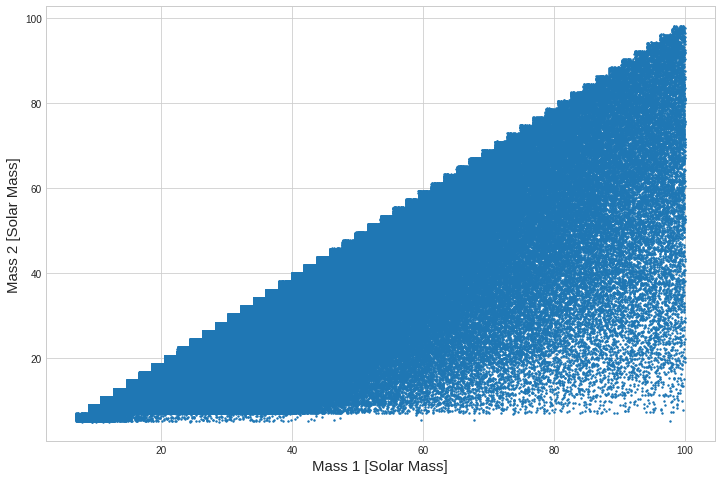

In [34]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Mass1'], BHCat['Mass2'], s=2)
plt.xlabel('Mass 1 [Solar Mass]', fontsize = 15)
plt.ylabel('Mass 2 [Solar Mass]', fontsize = 15)
plt.savefig('MassesScatterplot.png',dpi=500)

Together with a scatter plot for the spin amplitude:


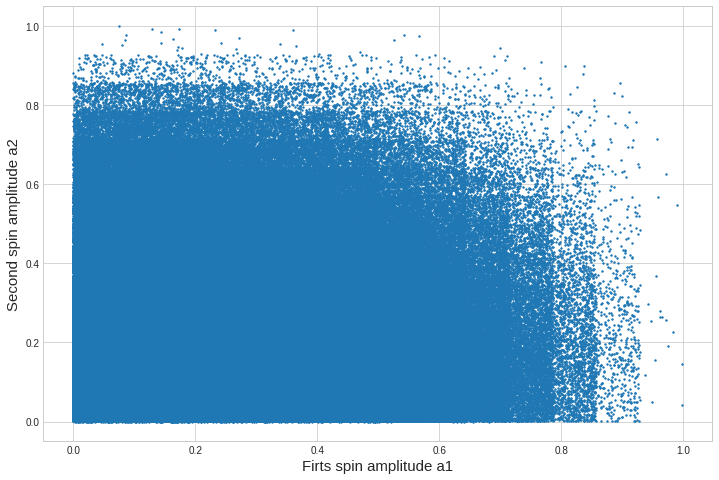

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Spin1'], BHCat['Spin2'], s=2)
plt.xlabel('Firts spin amplitude a1', fontsize = 15)
plt.ylabel('Second spin amplitude a2', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)
plt.savefig('SpinAmplitudesScatterplot.png',dpi=500)

Finally, the properties of the generated dataframe may be observed from an histogram of the frequencies :

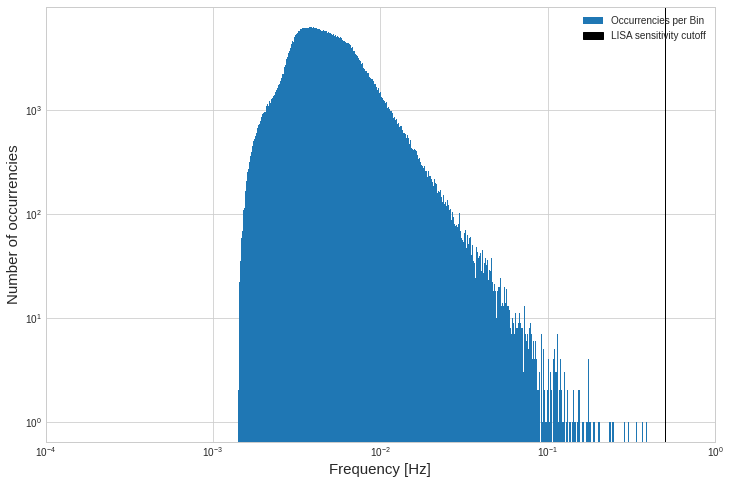

In [36]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(-4,0,1000)
plt.hist(BHCat['InitialFrequency'], bins = log_bin, label = 'Occurrencies per Bin')
plt.xlabel('Frequency [Hz]', fontsize = 15)
plt.xlim(10**(-4),1)
plt.axvspan(frq_max-0.001, frq_max + 0.001, 0, 1, color = 'black', label = 'LISA sensitivity cutoff')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)

and an hystogram showing the time of each event inside the LISA band :

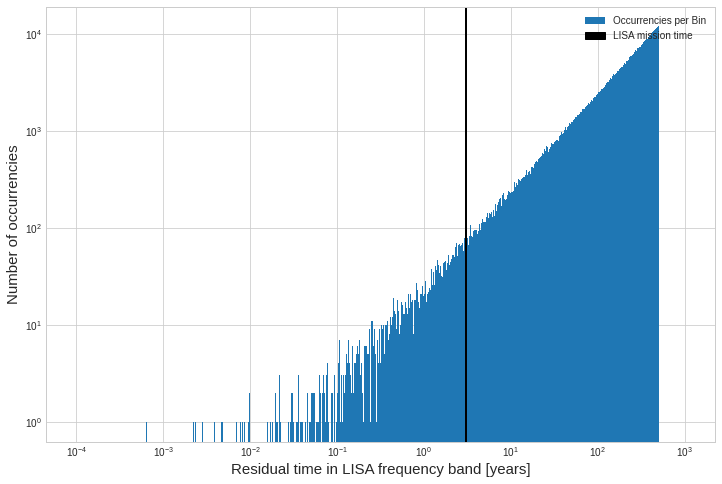

In [37]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(-4,3,1000)
plt.hist(BHCat['InBandTime'], bins = log_bin, label = 'Occurrencies per Bin')
plt.xlabel('Residual time in LISA frequency band [years]', fontsize = 15 )
plt.axvspan(T_obs - 0.01, T_obs + 0.01, 0, 1, color = 'black', label = 'LISA mission time')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('TimeInFrequencyBand.png',dpi=500)

Lastly, let's convert the dataframe to the standard LISA type dataframe :

In [39]:
LH = LISAhdf5('LISA'+df_nm)
pr = ParsUnits()

for p in list(SOBBHsunits.keys()):
    pr.addPar(p,BHCat[p],SOBBHsunits[p])

pr.addPar("SourceType",df_key, "name")    
LH.addSource('SOBBH',pr, overwrite=True)   
